In [1]:
library(tidyverse)
library(WGCNA)
library(glmnet)

# Custom package
library(rutils)

-- Attaching packages ------------------------------------------------------------------------------- tidyverse 1.3.0 --

v ggplot2 3.3.3     v purrr   0.3.4
v tibble  3.0.6     v dplyr   1.0.4
v tidyr   1.1.2     v stringr 1.4.0
v readr   1.4.0     v forcats 0.5.1

-- Conflicts ---------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()

Loading required package: dynamicTreeCut

Loading required package: fastcluster


Attaching package: 'fastcluster'


The following object is masked from 'package:stats':

    hclust





Attaching package: 'WGCNA'


The following object is masked from 'package:stats':

    cor


Loading required package: Matrix


Attaching package: 'Matrix'


The following objects are masked from 'package:tidyr':

    expand, pack, unpack


Loaded glmnet 4.1



In [2]:
enableWGCNAThreads()

Allowing parallel execution with up to 15 working processes.


In [3]:
# Define constants
dirs <- rutils::get_dev_directories(dev_paths_file = "../dev_paths.txt")
projects <- c("TCGA-CESC", "TCGA-UCS", "TCGA-UCEC", "TCGA-OV")
unified_dsets <- c("unified_cervical_data", "unified_uterine_data", "unified_uterine_endometrial_data")
matrisome_path <- paste0(dirs$data_dir, "/matrisome/matrisome_hs_masterlist.tsv")

event_code <- list("Alive" = 0, "Dead" = 1)
# covariate_cols_no_figo <- c("age_at_diagnosis", "race", "ethnicity")
# covariate_cols <- c("figo_stage", covariate_cols_no_figo)
covariate_cols <- c("figo_stage")
dep_cols <- c("vital_status", "survival_time")


In [4]:
dset_idx <- 3
save_res <- TRUE
# Worst performance observed in CESC
worst_score <- 0.6864

In [5]:
survival_path <- paste0(dirs$data_dir, "/", unified_dsets[dset_idx], "/survival_data.tsv")
survival_df <- load_survival_df(survival_path, event_code)
demg_list <- read_lines(paste0(dirs$analysis_dir, "/gene_lists/", unified_dsets[dset_idx], "_demg_list.txt"))


-- Column specification ------------------------------------------------------------------------------------------------
cols(
  sample_name = col_character(),
  vital_status = col_character(),
  survival_time = col_double(),
  figo_stage = col_character(),
  days_to_last_follow_up = col_double(),
  days_to_death = col_double(),
  age_at_diagnosis = col_double(),
  age_at_index = col_double(),
  height = col_double(),
  weight = col_double(),
  bmi = col_double(),
  race = col_character(),
  ethnicity = col_character()
)




In [6]:
# Load and filter survival data
filtered_survival_df <- survival_df %>%
    decode_figo_stage(to = "c") %>%
    dplyr::select(sample_name, figo_stage) %>% # make sure using same samples as classification models
    dplyr::filter(rowSums(is.na(.)) == 0)

# Load normalized matrisome count data
norm_matrisome_counts_path <- paste0(dirs$data_dir, "/", unified_dsets[dset_idx], "/norm_matrisome_counts.tsv")
norm_survival_counts_t_df <- read_tsv(norm_matrisome_counts_path) %>%
    dplyr::select(c("geneID", filtered_survival_df$sample_name)) %>%
    transpose_df("geneID", "sample_name")

# Combine survival data and normalized count data
joined_df <- filtered_survival_df %>%
    inner_join(norm_survival_counts_t_df, by = "sample_name")


-- Column specification ------------------------------------------------------------------------------------------------
cols(
  .default = col_double(),
  geneID = col_character()
)
i Use `spec()` for the full column specifications.




In [7]:
y <- as.vector(joined_df$figo_stage)

x <- as.matrix(
    joined_df %>%
        dplyr::select(-c(sample_name, figo_stage))
)
rownames(x) <- joined_df$sample_name

In [8]:
joined_df %>%
    group_by(figo_stage) %>%
    count() 
ns <- joined_df %>%
    group_by(figo_stage) %>%
    count() %>%
    pull(n)

figo_stage,n
<chr>,<int>
figo_stage_1,75
figo_stage_2,19
figo_stage_3,39
figo_stage_4,7


In [9]:
figo_weights = rep(0, length(y))
c <- length(unique(y))
# Weights sum to n
figo_weights[y == "figo_stage_1"] <- length(y) / (c * ns[1])
figo_weights[y == "figo_stage_2"] <- length(y) / (c * ns[2])
figo_weights[y == "figo_stage_3"] <- length(y) / (c * ns[3])
figo_weights[y == "figo_stage_4"] <- length(y) / (c * ns[4])

In [10]:
set.seed(123)
cv_mr_model <- cv.glmnet(
    x, y, family = "multinomial", alpha = 1,
    nfolds = 5, weights = figo_weights, type.measure = "class",
#     type.multinomial = "grouped", nlambda = 1000, parallel = TRUE
    type.multinomial = "grouped", parallel = TRUE,
#     lambda = seq(1, 0.005, -0.005)
    lambda = exp(seq(-5, 0, 0.005))
)

Warning message in lognet(xd, is.sparse, ix, jx, y, weights, offset, alpha, nobs, :
"one multinomial or binomial class has fewer than 8  observations; dangerous ground"


In [11]:
exp(seq(-5, 0, 0.005)) %>%
    length()

[1] 1001


Call:  cv.glmnet(x = x, y = y, weights = figo_weights, lambda = exp(seq(-5,      0, 0.005)), type.measure = "class", nfolds = 5, parallel = TRUE,      family = "multinomial", alpha = 1, type.multinomial = "grouped") 

Measure: Misclassification Error 

    Lambda Index Measure      SE Nonzero
min 0.1950   328  0.6251 0.05576       7
1se 0.2288   296  0.6737 0.05703       4

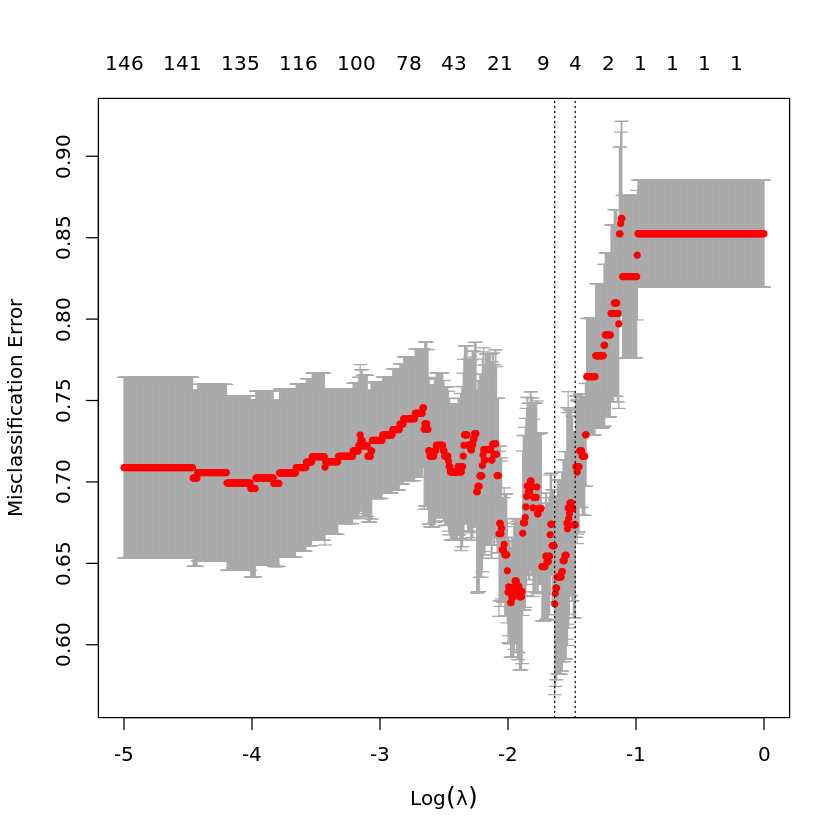

In [12]:
cv_mr_model
plot(cv_mr_model)

In [13]:
# Last index better than worst best score of any cancer model
lambda_idx <- max(which(cv_mr_model$cvm < worst_score))

# mask_lambda <- cv_mr_model$lambda.min
# mask_lambda_genes <- as.matrix(coef(cv_mr_model, s = mask_lambda))[, 1] != 0
# subscript [-1, ...] is to skip the coefficient
# Since we're using "grouped", coefficients are same for each level of figo stage
mask_lambda <- cv_mr_model$lambda[lambda_idx]
mask_1 <- as.matrix(coef(cv_mr_model, s = mask_lambda)$figo_stage_1)[-1, 1] != 0
mask_2 <- as.matrix(coef(cv_mr_model, s = mask_lambda)$figo_stage_2)[-1, 1] != 0
mask_3 <- as.matrix(coef(cv_mr_model, s = mask_lambda)$figo_stage_3)[-1, 1] != 0
mask_4 <- as.matrix(coef(cv_mr_model, s = mask_lambda)$figo_stage_4)[-1, 1] != 0
all(mask_1 == mask_2)
all(mask_1 == mask_3)
all(mask_1 == mask_4)

[1] TRUE

[1] TRUE

[1] TRUE

In [14]:
cv_mr_model$lambda[lambda_idx]
cv_mr_model$cvm[lambda_idx]

[1] 0.1261858

[1] 0.6681743

In [15]:
coefs_1 <- as.matrix(coef(cv_mr_model, s = mask_lambda)$figo_stage_1)[-1, 1]
coefs_2 <- as.matrix(coef(cv_mr_model, s = mask_lambda)$figo_stage_2)[-1, 1]
coefs_3 <- as.matrix(coef(cv_mr_model, s = mask_lambda)$figo_stage_3)[-1, 1]
coefs_4 <- as.matrix(coef(cv_mr_model, s = mask_lambda)$figo_stage_4)[-1, 1]

## Weighted baseline

In [16]:
maj_class <- which.max(ns)

In [17]:
weighted_baseline <- 1 - sum(figo_weights[y == paste0("figo_stage_", maj_class)]) / sum(figo_weights)

In [18]:
weighted_baseline
cv_best_cvm <- cv_mr_model$cvm[cv_mr_model$index["min",]]

[1] 0.75

In [19]:
(cv_best_cvm - weighted_baseline) / weighted_baseline

[1] -0.1664906

In [20]:
important_gene_df <- tibble(
    geneID = colnames(x)[mask_1],
    figo_stage_1_coefs = coefs_1[mask_1],
    figo_stage_2_coefs = coefs_1[mask_1],
    figo_stage_3_coefs = coefs_1[mask_1],
    figo_stage_4_coefs = coefs_1[mask_1],
)
nrow(important_gene_df)

[1] 20

In [21]:
param_length <- length(cv_mr_model$lambda)
# param_length
kept_idx <- rep(FALSE, param_length)
kept_idx[lambda_idx] = TRUE
best_idx <- rep(FALSE, param_length)
best_idx[[cv_mr_model$index["min",]]] = TRUE

In [22]:
fit_details_df <- tibble(
    cvm = cv_mr_model$cvm,
    lambda = cv_mr_model$lambda,
    cvlow = cv_mr_model$cvlo,
    cvup = cv_mr_model$cvup,
    nonzero = cv_mr_model$nzero,
    kept_idx = kept_idx,
    best_idx = best_idx,
)

In [29]:
# extra_meta_df <- tibble(
#     cv_mr_model$index
# )

# Subtract 1 for intercept
cv_mr_model$nzero[best_idx] - 1
cv_mr_model$nzero[kept_idx] - 1

s327 
   6

s414 
  20

In [24]:
kept_df <- as.matrix(coef(cv_mr_model, s = mask_lambda)$figo_stage_1)[-1, 1] %>%
    as_tibble(rownames = "geneID") %>%
    rename(kept = value)
best_df <- as.matrix(coef(cv_mr_model, s = cv_mr_model$lambda.min)$figo_stage_1)[-1, 1] %>%
    as_tibble(rownames = "geneID") %>%
    rename(best = value)
best_kept_df <- inner_join(kept_df, best_df, by = "geneID")

In [25]:
if (save_res) {
    write_tsv(important_gene_df, paste0(dirs$analysis_dir, "/feature_selection/", unified_dsets[dset_idx], "_en_multinom_results.tsv"))
    write_tsv(fit_details_df, paste0(dirs$analysis_dir, "/model_opt/", unified_dsets[dset_idx], "_en_mr_fit_data.tsv"))
    write_tsv(best_kept_df, paste0(dirs$analysis_dir, "/feature_selection/", unified_dsets[dset_idx], "_en_multinom_full_best_kept_coef.tsv"))
}